In [1]:
import pandas as pd
import numpy as np

# Load main table
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')


# bureau = pd.read_csv('bureau.csv')
# bureau_balance = pd.read_csv('bureau_balance.csv')
# prev = pd.read_csv('previous_application.csv')
# inst = pd.read_csv('installments_payments.csv')
# pos = pd.read_csv('POS_CASH_balance.csv')
# credit = pd.read_csv('credit_card_balance.csv')

print(f"Train shape: {app_train.shape}, Test shape: {app_test.shape}")


Train shape: (307511, 122), Test shape: (48744, 121)


In [2]:
# Target distribution
print(app_train['TARGET'].value_counts(normalize=True))

# Fill missing
app_train = app_train.fillna(-999)
app_test = app_test.fillna(-999)

# Example ratio features
app_train['CREDIT_INCOME_RATIO'] = app_train['AMT_CREDIT'] / (app_train['AMT_INCOME_TOTAL'] + 1)
app_train['ANNUITY_INCOME_RATIO'] = app_train['AMT_ANNUITY'] / (app_train['AMT_INCOME_TOTAL'] + 1)

# Apply the same ratio features to app_test
app_test['CREDIT_INCOME_RATIO'] = app_test['AMT_CREDIT'] / (app_test['AMT_INCOME_TOTAL'] + 1)
app_test['ANNUITY_INCOME_RATIO'] = app_test['AMT_ANNUITY'] / (app_test['AMT_INCOME_TOTAL'] + 1)


# Label encoding categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in app_train.select_dtypes(include='object').columns:
    app_train[col] = le.fit_transform(app_train[col].astype(str))
    app_test[col] = le.transform(app_test[col].astype(str))

# TODO: You can write merge functions to pull aggregated features from other tables (e.g., mean of overdue days from bureau)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

X = app_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = app_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = LGBMClassifier(n_estimators=500, max_depth=8, learning_rate=0.03)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(f"Validation AUC: {auc:.4f}")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11819
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Validation AUC: 0.7608


In [4]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


[[56474    64]
 [ 4861   104]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.62      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.77      0.51      0.50     61503
weighted avg       0.90      0.92      0.88     61503



In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Define the model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    # subsample=0.8,
    # colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate
xgb_auc = roc_auc_score(y_val, xgb_preds)
print(f"XGBoost Validation AUC: {xgb_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:59:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation AUC: 0.7544


In [6]:
lgbm_preds = model.predict_proba(X_val)[:, 1]
lgbm_auc = roc_auc_score(y_val, lgbm_preds)

print(f"LightGBM AUC:  {lgbm_auc:.4f}")
print(f"XGBoost AUC:   {xgb_auc:.4f}")


LightGBM AUC:  0.7608
XGBoost AUC:   0.7544


In [7]:
app_test.head()


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.213302,0.152299
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,2.250159,0.175453
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,4.0,3.275362,0.344576
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,4.999984,0.155614
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.474981,0.178149


In [7]:
# Drop target and ID from train
X_train_final = app_train.drop(columns=['TARGET', 'SK_ID_CURR'])
X_test_final = app_test.drop(columns=['SK_ID_CURR'])

# 1. Compare number of columns
print(f"Train shape: {X_train_final.shape}, Test shape: {X_test_final.shape}")

# 2. Check if columns match
missing_in_test = set(X_train_final.columns) - set(X_test_final.columns)
missing_in_train = set(X_test_final.columns) - set(X_train_final.columns)

if not missing_in_test and not missing_in_train:
    print("Column names match!")
else:
    print("Column mismatch!")
    print("Missing in test:", missing_in_test)
    print("Missing in train:", missing_in_train)

# 3. Check column order (important for tree models)
if list(X_train_final.columns) == list(X_test_final.columns):
    print("Column order matches!")
else:
    print("Column order mismatch – reordering test columns to match train")
    X_test_final = X_test_final[X_train_final.columns]


Train shape: (307511, 122), Test shape: (48744, 122)
Column names match!
Column order matches!


In [8]:
# Predict default probability using LGBM
lgbm_test_preds = model.predict_proba(X_test_final)[:, 1]

# Create submission DataFrame
submission_lgbm = pd.DataFrame({
    'SK_ID_CURR': app_test['SK_ID_CURR'],
    'TARGET': lgbm_test_preds
})

# Save as CSV
submission_lgbm.to_csv('lgbm_test_predictions.csv', index=False)
print("LightGBM predictions saved to 'lgbm_test_predictions.csv'")


LightGBM predictions saved to 'lgbm_test_predictions.csv'


In [9]:
# Predict default probability using XGBoost
xgb_test_preds = xgb_model.predict_proba(X_test_final)[:, 1]

# Create submission DataFrame
submission_xgb = pd.DataFrame({
    'SK_ID_CURR': app_test['SK_ID_CURR'],
    'TARGET': xgb_test_preds
})

# Save as CSV
submission_xgb.to_csv('xgb_test_predictions.csv', index=False)
print("XGBoost predictions saved to 'xgb_test_predictions.csv'")


XGBoost predictions saved to 'xgb_test_predictions.csv'


In [10]:
# Show top 5 riskiest applicants by XGBoost
submission_xgb.sort_values(by='TARGET', ascending=False).head()


,SK_ID_CURR,TARGET
2764,119362,0.629504
8865,164766,0.622831
20706,250236,0.567454
22815,265895,0.543888
13083,195050,0.540795


In [11]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)  # for validation set




/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


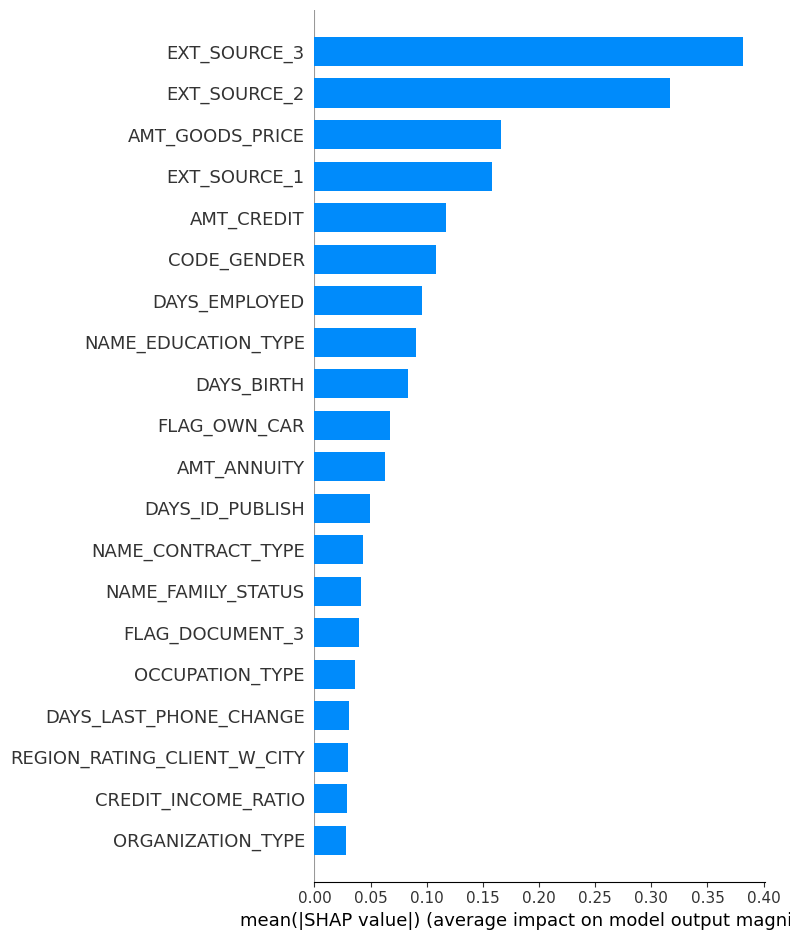

In [12]:
shap.summary_plot(shap_values, X_val, plot_type='bar')
